Install MedMNIST

In [476]:
# !pip install medmnist

Imports

In [477]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

import einops

In [478]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


We first work on a 2D dataset with size 28x28

In [479]:
data_flag = 'breastmnist'
# data_flag = 'breastmnist' OR 'pathmnist"
download = True

NUM_EPOCHS = 3
batch_size = 2
lr = 0.001

device = "cuda:0" if torch.cuda.is_available() else "cpu"
patch_size = 14
latent_size = 28
n_channels = 1
num_heads = 2
num_encoders = 12
dropout = 0.1
num_classes = 2
#size = 28


info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [480]:
print(info)
print(task)
print(n_channels)
print(n_classes)
print(DataClass)

{'python_class': 'BreastMNIST', 'description': 'The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.', 'url': 'https://zenodo.org/records/10519652/files/breastmnist.npz?download=1', 'MD5': '750601b1f35ba3300ea97c75c52ff8f6', 'url_64': 'https://zenodo.org/records/10519652/files/breastmnist_64.npz?download=1', 'MD5_64': '742edef2a1fd1524b2efff4bd7ba9364', 'url_128': 'https://zenodo.org/records/10519652/files/breastmnist_128.npz?download=1', 'MD5_128': '363e4b3f8d712e9b5de15470a2aaadf1', 'url_224': 'https://zenodo.org/records/10519652/files/breastmnist_224.npz?download=1', 'MD5_224': 'b5637

First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [481]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(), #from PIL (Python Image Library Format) to PyTorch Tensor, normalised to [0,1]
    transforms.Normalize(mean=[.5], std=[.5]) #(image-mean)/std --> scaling [-1,1]
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False) #2*batch_size
test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False) #2*batch_size

In [482]:
print(train_dataset)
print("===================")
print(test_dataset)
print("===================")
print(train_loader)

Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 546
    Root location: /home/wiebketeetz/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC BY 4.0
Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 156
    Root location: /home/wiebketeetz/.medmnist
    Split: test
    Task: binary-class
    Number of channels: 1

In [483]:
# visualization

train_dataset.montage(length=1)

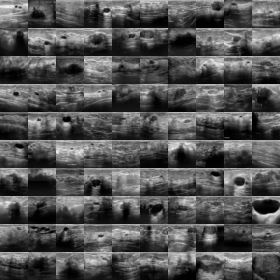

In [484]:
# montage

train_dataset.montage(length=10)

Set Parameters and Implement Encoder-Block for ViT

In [485]:
class InputEmbedding(nn.Module):
    def __init__(self, patch_size = patch_size, n_channels = n_channels, device = device, latent_size = latent_size, batch_size = batch_size):
        super(InputEmbedding, self).__init__()
        self.latent_size = latent_size
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.device = device
        self.batch_size = batch_size
        self.input_size = self.patch_size*self.patch_size*self.n_channels

        #Linear Projection
        self.linearProjection = nn.Linear(self.input_size, self.latent_size)

        #Class Token
                                              # how many in 1 batch? 1Token  dimensions
        self.class_token = nn.Parameter(torch.randn(self.batch_size, 1, self.latent_size)).to(self.device)

        #Positional Embedding
        self.pos_embedding =nn.Parameter(torch.randn(self.batch_size, 1, self.latent_size)).to(self.device)

    def forward(self, input_data):
        input_data = input_data.to(self.device)

        # Patchify Input Image
        patches = einops.rearrange(
            input_data, "b c (h h1) (w w1) -> b (h w) (h1 w1 c)", h1 = self.patch_size, w1 = self.patch_size)
        
        #print(input_data.size())
        #print(patches.size())

        linear_projection = self.linearProjection(patches).to(self.device)
        b, n, _ = linear_projection.shape

        linear_projection = torch.cat((self.class_token, linear_projection), dim = 1) #entlang der 1. Dim hinzugefügt
        pos_embed = einops.repeat(self.pos_embedding, "b 1 d -> b m d", m = n + 1)
        
        #print(linear_projection.size())
        #print(pos_embed.size())

        linear_projection += pos_embed

        return linear_projection

In [486]:
class EncoderBlock(nn.Module):
    def __init__(self, latent_size = latent_size, num_heads = num_heads, device = device, dropout = dropout):
        super(EncoderBlock, self).__init__()

        self.latent_size = latent_size
        self.num_heads = num_heads
        self.device = device
        self.dropout = dropout

        #Normalization layer
        self.norm = nn.LayerNorm(self.latent_size)
      
        self.multihead = nn.MultiheadAttention(
            self.latent_size, self.num_heads, dropout = self.dropout)
        
        self.enc_MLP = nn.Sequential(
            nn.Linear(self.latent_size, self.latent_size*4),
            nn.GELU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.latent_size*4,self.latent_size),
            nn.Dropout(self.dropout)
        )

    def forward(self, embedded_patches):
        firstnorm_out = self.norm(embedded_patches)
        attention_out = self.multihead(firstnorm_out, firstnorm_out, firstnorm_out)[0]

        #first residual connection
        first_added = attention_out + embedded_patches

        secondnorm_out = self.norm(first_added)
        ff_output = self.enc_MLP(secondnorm_out)

        output = ff_output + first_added

        #print(embedded_patches.size())
        #print(output.size())

        return output

Test Encoder Block

In [487]:
sample1 = train_dataset[0]
image_tensor1, label1 = sample1

sample2 = train_dataset[0]
image_tensor2, label2 = sample2

test_encoder = EncoderBlock().to(device)
test_encoder(image_tensor1)

tensor([[[-9.4919e-01,  2.4106e-01, -6.3573e-01,  2.8709e-02, -1.5172e-01,
          -3.9708e-01, -2.0532e-01,  1.1669e-01,  1.9279e-01, -1.8318e-01,
           7.6255e-02,  4.1557e-01, -4.2966e-01, -2.7129e-01, -1.0343e-01,
           6.5840e-01,  5.4408e-02,  9.2099e-01, -2.0032e-01, -4.5554e-01,
           4.2185e-01,  5.3398e-01,  1.2559e-01,  4.9304e-01,  4.1039e-01,
           1.3242e+00,  1.0150e+00,  8.0876e-01],
         [-1.2033e+00, -6.9279e-01, -7.2954e-01, -4.3783e-01, -7.5888e-01,
          -6.9230e-01, -4.9169e-01, -3.3317e-01, -8.6792e-01,  7.2784e-02,
          -5.9542e-01, -2.3034e-01, -2.3452e-01,  2.8725e-01, -4.2595e-01,
           4.2626e-01,  9.2962e-03,  1.5122e-01, -6.7857e-01, -1.4937e-01,
           2.0373e-01,  5.0587e-02,  2.5121e-01,  1.2397e-01, -2.0231e-02,
           6.1659e-01,  2.0675e-01, -1.0351e-02],
         [-1.1668e+00, -1.2070e+00, -4.7040e-01,  3.6828e-01, -8.4650e-01,
          -8.4825e-01, -5.1181e-01, -2.5656e-01, -6.5321e-01, -4.8642e-01,


Implement ViT

In [488]:
class ViT(nn.Module):
    def __init__(self, num_encoders=num_encoders, latent_size=latent_size, device=device, num_classes=num_classes, dropout=dropout):
        super(ViT, self).__init__()

        self.num_encoders = num_encoders
        self.latent_size = latent_size
        self.device = device
        self.num_classes = num_classes
        self.dropout = dropout

        self.embedding = InputEmbedding()

        #Create Stack of Encoders
        self.encStack = nn.ModuleList(EncoderBlock() for i in range(self.num_encoders))

        self.MLP_head = nn.Sequential(
            nn.LayerNorm(self.latent_size),
            nn.Linear(self.latent_size, self.latent_size),
            nn.Linear(self.latent_size, self.num_classes)
        )

    def forward(self, test_input):
        enc_output = self.embedding(test_input)

        for enc_layer in self.encStack:
            enc_output = enc_layer(enc_output)

        cls_token_embed = enc_output[:, 0]

        return self.MLP_head(cls_token_embed)

In [489]:
model = ViT().to(device)

Test ViT

In [490]:
print(image_tensor1.size())
image_tensor1_vit = image_tensor1.unsqueeze(0)
image_tensor2_vit = image_tensor2.unsqueeze(0)
image_tensor = torch.cat((image_tensor1_vit, image_tensor2_vit), dim = 0)

vit_output = model(image_tensor)

print(vit_output)
print(vit_output.size())

torch.Size([1, 28, 28])
tensor([[-0.2176,  0.0025],
        [ 0.6370,  0.0712]], grad_fn=<AddmmBackward0>)
torch.Size([2, 2])


Define the Loss Function

In [491]:
# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

Next, we start to train and evaluate!

In [492]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
           
            targets = targets.squeeze(dim = 1).long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

  0%|          | 0/273 [00:00<?, ?it/s]

100%|██████████| 273/273 [00:03<00:00, 70.10it/s]


In [493]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            print(inputs.shape)
            outputs = model(inputs)
            print(outputs.shape)
            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

        
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
torch.Size([2, 1, 28, 28])
torch.Size([2, 2])
torch.Size([2, 1, 28, 28])
torch.Size([2, 2])
torch.Size([2, 1, 28, 28])
torch.Size([2, 2])
torch.Size([2, 1, 28, 28])
torch.Size([2, 2])
torch.Size([2, 1, 28, 28])
torch.Size([2, 2])
torch.Size([2, 1, 28, 28])
torch.Size([2, 2])
torch.Size([2, 1, 28, 28])
torch.Size([2, 2])
torch.Size([2, 1, 28, 28])
torch.Size([2, 2])
torch.Size([2, 1, 28, 28])
torch.Size([2, 2])
torch.Size([2, 1, 28, 28])
torch.Size([2, 2])
torch.Size([2, 1, 28, 28])
torch.Size([2, 2])
torch.Size([2, 1, 28, 28])
torch.Size([2, 2])
torch.Size([2, 1, 28, 28])
torch.Size([2, 2])
torch.Size([2, 1, 28, 28])
torch.Size([2, 2])
torch.Size([2, 1, 28, 28])
torch.Size([2, 2])
torch.Size([2, 1, 28, 28])
torch.Size([2, 2])
torch.Size([2, 1, 28, 28])
torch.Size([2, 2])
torch.Size([2, 1, 28, 28])
torch.Size([2, 2])
torch.Size([2, 1, 28, 28])
torch.Size([2, 2])
torch.Size([2, 1, 28, 28])
torch.Size([2, 2])
torch.Size([2, 1, 28, 28])
torch.Size([2, 2])
torch.Size([2, 